# Step F8A: Analysis of poor prediciton result for $AMC

## 1. Import required libraries

In [6]:
import pandas as pd
from datetime import datetime
import re
import numpy as np
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import os
import ast

from scipy import stats
from sklearn import preprocessing
import tensorflow as tf
from keras.utils import np_utils
from keras import backend as bck
from sklearn.metrics import r2_score
from keras.wrappers.scikit_learn import KerasRegressor

import seaborn as sns
import matplotlib.pyplot as plt
import pickle

## 2. Data Preparation
*Define a data preparation function to perform the following*
- 1. Scaling
- 2. Windowing
- 3. Splitting into train, test and validation datasets
- 4. convert datasets to tensors

In [7]:
#--Global variables to be used for dataprep
TRAIN_TESTVAL_SPLIT = 0.28 #what % of data to assign for test and validation datasets
TEST_VAL_SPLIT = 0.5 #what percentage of test data to assign for validation dataset
BATCH_SIZE = 5
N_TIME_STEPS = 5 #sliding window length
STEP = 1 #Since we have very little data, we set the sliding window step size as 1
N_FEATURES = 19
scaler = MinMaxScaler(feature_range = (-1, 1))


#--Function to complete all dataprep steps and return required datasets
def complete_data_prep(data_df):
    #--Scaling   
#     data_df = data_df[['ACD','MACD','CHO','Highest_T','Lowest_T','S-K','S-D','VPT','W-R','RSI','MOME','AC','PROC','VROC','OBV','positive','neutral','negative','log_ret-t','Close']]
    data_df.iloc[:] = scaler.fit_transform(data_df.iloc[:].values)

    def data_split_and_sliding_window(x, train_testval_split, test_val_split, n_time_steps, step):

        def sliding_window_fnc(x, n_time_steps, step):
            input_window = []
            output_window = []
            len_x = x.shape[0]
            for i in range(0, len_x-n_time_steps, step):
                input_window.append(x.iloc[i:i+n_time_steps, 0:-1].values)
                output_window.append(x.iloc[i+n_time_steps, -1])
            print('I/O Window lengths', len(np.array(input_window)), len(np.array(output_window)))
            return np.array(input_window), np.array(output_window)

        windowed_dataset_x, windowed_dataset_y = sliding_window_fnc(x, n_time_steps, step)

        #--Split dataset into trianing, testing and validation sets
        full_window_length = len(windowed_dataset_x)
        training_data_length = round((1-TRAIN_TESTVAL_SPLIT)*full_window_length)
        validation_data_length = (full_window_length - training_data_length)/2 
        testing_data_length = full_window_length - validation_data_length - training_data_length

        val_recs_end = round(training_data_length + validation_data_length)

        train_x = windowed_dataset_x[0:training_data_length]
        train_y = windowed_dataset_y[0:training_data_length]
        val_x = windowed_dataset_x[training_data_length:val_recs_end]
        val_y = windowed_dataset_y[training_data_length:val_recs_end]
        test_x = windowed_dataset_x[val_recs_end:]
        test_y = windowed_dataset_y[val_recs_end:]
        
        print(f'Length of training data = x: {len(train_x)}, y: {len(train_y)}')
        print(f'Length of val data = x: {len(val_x)}, y: {len(val_y)}')
        print(f'Length of test data = x: {len(test_x)}, y: {len(test_y)}')

        return train_x, train_y, test_x, test_y, val_x, val_y
    
    def tf_dataset(series_x, series_y, batch_size, shuffle_buffer, shuffle=True):
        ds = tf.data.Dataset.from_tensor_slices((series_x, series_y))
        if shuffle:
            ds = ds.cache().shuffle(shuffle_buffer).batch(batch_size).repeat()
        else:
            ds = ds.cache().batch(batch_size).repeat()

        return ds


    data_train_x, data_train_y, data_val_x, data_val_y, data_test_x, data_test_y = data_split_and_sliding_window(data_df,TRAIN_TESTVAL_SPLIT,TEST_VAL_SPLIT,N_TIME_STEPS,STEP)

    train_set = tf_dataset(data_train_x, data_train_y, BATCH_SIZE, 1000)
    unshuffled_train_set = tf_dataset(data_train_x, data_train_y, BATCH_SIZE, 1000, False)
    validation_set = tf_dataset(data_val_x, data_val_y, 5, 1000, False)
    test_set = tf_dataset(data_test_x, data_test_y, BATCH_SIZE, 1000, False)

    return data_train_x.shape[0], data_train_x.shape[1], data_train_x.shape[2], data_val_x.shape[0], data_test_x.shape[0], train_set, unshuffled_train_set, validation_set, test_set, data_train_y, data_val_y, data_test_y
    

## 3. Model preparation
*Define a function to house the CNN-LSTM model and to return the results of predictions and metrics*

In [8]:
def build_model_and_predict(train_set, unshuffled_train_set, validation_set, test_set,
                            data_train_y, data_val_y, data_test_y,
                            train_x_shape_0, trains_x_shape_1, train_x_shape_2, val_x_shape_0, test_x_shape_0,
                            batch_size=5,epochs=20,
                            optimizer_fnc='Adam', learning_rt=0.001, 
                            conv_filters=32, conv_activation='tanh', conv_kernel_size=1,
                            second_conv_layer=False, second_conv_filters=64, second_conv_activation='tanh', second_conv_kernel_size=2,
                            pool_size=2, 
                            lstm_units=64, 
                            second_dense_layer=False, dense_units=32):

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv1D(filters=conv_filters,
                                       kernel_size=conv_kernel_size,
                                       strides=1,
                                       padding="same",
                                       activation=conv_activation,
                                       input_shape=(train_x_shape_1,train_x_shape_2))
                                 )
    if second_conv_layer == True:
        model.add(tf.keras.layers.Conv1D(filters=second_conv_filters,
                                           kernel_size=second_conv_kernel_size,
                                           strides=1,
                                           padding="same",
                                           activation=second_conv_activation,
                                           input_shape=((train_x_shape_1-conv_kernel_size)+1,conv_filters))
                                     )
    model.add(tf.keras.layers.MaxPooling1D(pool_size=pool_size, strides=1, padding="same"))
    model.add(tf.keras.layers.LSTM(lstm_units, return_sequences=True))
    model.add(tf.keras.layers.Flatten())
    if second_dense_layer == True:
        model.add(tf.keras.layers.Dense(dense_units))
    model.add(tf.keras.layers.Dense(1))

    OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=learning_rt)

    if optimizer_fnc == 'SGD':
        OPTIMIZER = tf.keras.optimizers.SGD(learning_rate=learning_rt)
    elif optimizer_fnc == 'Nadam':
        OPTIMIZER = tf.keras.optimizers.Nadam(learning_rate=learning_rt)
    elif optimizer_fnc == 'RMSprop':
        OPTIMIZER = tf.keras.optimizers.RMSprop(learning_rate=learning_rt)
    elif optimizer_fnc == 'Adadelta':
        OPTIMIZER = tf.keras.optimizers.Adadelta(learning_rate=learning_rt)
    elif optimizer_fnc == 'Adagrad':
        OPTIMIZER = tf.keras.optimizers.Adagrad(learning_rate=learning_rt)
    elif optimizer_fnc == 'Adamax':
        OPTIMIZER = tf.keras.optimizers.Adamax(learning_rate=learning_rt)        

    model.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=OPTIMIZER, metrics=['mae'])

    train_step = math.ceil(train_x_shape_0/5)
    validation_step = math.ceil(val_x_shape_0/5)
    test_step = math.ceil(test_x_shape_0/5)

    #--Model training
    history = model.fit(train_set,
                        epochs=epochs,
                        steps_per_epoch=train_step,
                        validation_data=validation_set,
                        validation_steps=validation_step,
                        verbose=0)
    
    loss_train = history.history['loss']
    loss_val = history.history['val_loss']
    diff_in_loss=abs(np.subtract(loss_val,loss_train));
    loss_df = pd.DataFrame({'loss_train':loss_train, 'loss_val':loss_val, 'diff_in_loss':diff_in_loss})

    #--Model prediction
    pred_train_x = model.predict(unshuffled_train_set, steps=train_step)
    pred_val_x = model.predict(validation_set, steps=validation_step)
    pred_test_x = model.predict(test_set, steps=test_step)

    predictions = np.concatenate((pred_train_x[:,0], pred_val_x[:,0], pred_test_x[:,0]))
    true_vals = np.concatenate((data_train_y, data_val_y, data_test_y))

    #--Perform inverse scaling to get the price values
    true_val2 = np.c_[np.zeros((true_vals.shape[0],train_x_shape_2)), true_vals]
    temp_col_list = [str(i) for i in range(0,train_x_shape_2)]
    temp_col_list.append('Close')
    true_df = pd.DataFrame(true_val2, columns=temp_col_list)
    true_df.iloc[:] = scaler.inverse_transform(true_df.iloc[:].values)

    pred_val2 = np.c_[np.zeros((predictions.shape[0],train_x_shape_2)), predictions]
    pred_df = pd.DataFrame(pred_val2, columns=temp_col_list)
    pred_df.iloc[:] = scaler.inverse_transform(pred_df.iloc[:].values)

    close_data = [true_df["Close"], pred_df["Close"]]
    close_df = pd.concat(close_data, axis=1, keys=['true_close', 'pred_close'])

    #--Compute metrics
    def compute_perf_metrics(true_vals, pred_vals):    
        metrics_result = []

        keras_metrics = [
        tf.keras.metrics.MeanAbsoluteError(),
        tf.keras.metrics.RootMeanSquaredError(),
        tf.keras.metrics.MeanAbsolutePercentageError(),
        tf.keras.metrics.MeanSquaredError()
        ]

        for metric in keras_metrics:
            metric.reset_states()
            metric.update_state(true_vals, pred_vals)
            metrics_result.append(metric.result().numpy())  

        metrics_result.append(r2_score(true_vals, pred_vals))
        return metrics_result

    
    print(f'Training data lengths = data_train_y: {len(data_train_y)}, pred_train_x: {len(pred_train_x)}')
    print(f'Val data lengths = data_val_y: {len(data_val_y)}, pred_val_x: {len(pred_val_x)}')
    print(f'Test data lengths = data_test_y: {len(data_test_y)}, pred_test_x: {len(pred_test_x)}')
    
    
    train_metrics = compute_perf_metrics(data_train_y, pred_train_x)
    train_metrics.insert(0, 'Train')
    val_metrics = compute_perf_metrics(data_val_y, pred_val_x)
    val_metrics.insert(0, 'Validation')
    test_metrics = compute_perf_metrics(data_test_y, pred_test_x)
    test_metrics.insert(0, 'Test')

    COL_NAMES = ['dataset','MAE','RMSE','MAPE','MSE','R2']
    metrics_table = pd.DataFrame([train_metrics, val_metrics, test_metrics], columns=COL_NAMES)
#     metrics_table = metrics_table.set_index([''])
    metrics_table.round(5)

    return loss_df, close_df, metrics_table

## 4. Input data
*Read all the required input data into a dictionary from the pickle files saved in precious steps*

In [9]:
twitter_data_df = {}
twitter_date_df = {}

tick='AMC'

stock_df = pd.read_pickle(f"C:\\Users\\Karthik\\Desktop\\Dissertation\\Final_dfs\\{tick}_technical_data_df.pkl")

for i in range(1,5):
    
    model = f"model{i}"

    if model not in twitter_data_df:
        twitter_data_df[model] = {}

    twitter_sentiment_data = pd.DataFrame()

    if model=='model1':
        twitter_sentiment_data = pd.read_pickle(f"C:\\Users\\Karthik\\Desktop\\Dissertation\\Final_dfs\\twitter_{tick}_BERT_TwitterAirline_Even.pkl")

    elif model == 'model2':
        twitter_sentiment_data = pd.read_pickle(f"C:\\Users\\Karthik\\Desktop\\Dissertation\\Final_dfs\\twitter_{tick}_BERT_TwitterAirline_Uneven.pkl") 

    elif model == 'model3':
        twitter_sentiment_data = pd.read_pickle(f"C:\\Users\\Karthik\\Desktop\\Dissertation\\Final_dfs\\twitter_{tick}_BERT_Sentiment140.pkl")

    elif model == 'model4':
        twitter_sentiment_data = pd.read_pickle(f"C:\\Users\\Karthik\\Desktop\\Dissertation\\Final_dfs\\twitter_{tick}_finBERT.pkl")

    temp_twitter_data = pd.merge(stock_df, twitter_sentiment_data, how="inner", on="YearMonDay")

    #--Get the dates which will be used later for visualizations
    twitter_date_df[model] = temp_twitter_data['Date'].apply(lambda x: datetime.strftime(x, '%d-%m-%Y'))

    if model == 'model3':        
        twitter_data_df[model] = temp_twitter_data[['ACD','MACD','CHO','Highest_T','Lowest_T','S-K','S-D','VPT','W-R','RSI','MOME','AC','PROC','VROC','OBV','positive','negative','log_ret-t','Close']]
    else:
        twitter_data_df[model] = temp_twitter_data[['ACD','MACD','CHO','Highest_T','Lowest_T','S-K','S-D','VPT','W-R','RSI','MOME','AC','PROC','VROC','OBV','positive','neutral','negative','log_ret-t','Close']]


In [10]:
twitter_data_df

{'model1':               ACD      MACD           CHO  Highest_T   Lowest_T         S-K  \
 0   -8.005444e+05 -0.147083 -3.416734e+05   4.270000   3.870000  100.000000   
 1    1.763420e+06 -0.134887  3.360375e+05   4.160000   3.870000   90.908894   
 2    3.943050e+06 -0.078687  1.276253e+06   4.750000   3.870000  100.000000   
 3    1.252913e+06 -0.054646  6.889104e+05   4.750000   3.870000   56.923051   
 4   -6.988702e+06 -0.028612 -2.236326e+06   4.750000   3.870000   68.852456   
 ..            ...       ...           ...        ...        ...         ...   
 286 -1.624331e+06  0.167014  5.764738e+06  51.689999  38.820000   21.561331   
 287 -2.949727e+07 -0.066834 -2.941905e+05  51.689999  38.820000   80.952220   
 288 -2.085880e+07 -0.300484  2.507542e+03  51.689999  38.820000   38.095137   
 289 -6.292611e+07 -0.649258 -1.326140e+07  51.689999  36.990002    0.000000   
 290 -7.360678e+07 -1.019851 -2.088035e+07  51.689999  35.540001    0.000000   
 
            S-D           VP

*Read the tuned hyperparameters for all models in a dataframe*
- *The parameters for each ticker will be read from this dataframe and passed to the CNN-LSTM model*

In [11]:
tuning_results = pd.read_pickle(r'C:\\Users\\Karthik\\Desktop\\Dissertation\\Hyperparameter tuning\\Tuning_results.pkl')

## 5. Predict using CNN-LSTM models
- *Use input data to predict stock prices*
- *Save the results as csv files for later use*

In [12]:
path = r'C:\\Users\\Karthik\\Desktop\\Dissertation\\Plots and metrics\\Extra\\'

results_df = {}


for model, model_df in twitter_data_df.items():
    print('Performing training and prediction using twiiter sentiments with all available data for twitter')

    train_x_shape_0, train_x_shape_1, train_x_shape_2, val_x_shape_0, test_x_shape_0, train_set, unshuffled_train_set, validation_set, test_set, data_train_y, data_val_y, data_test_y = complete_data_prep(model_df)

    req_dict = tuning_results[tuning_results['ticker'] == "AMC"].to_dict('list')

    loss_df, close_df, metrics_table = build_model_and_predict(train_set, unshuffled_train_set, validation_set, test_set,
                                                                data_train_y, data_val_y, data_test_y,
                                                                train_x_shape_0, train_x_shape_1, train_x_shape_2, val_x_shape_0, test_x_shape_0,
                                                                batch_size=req_dict['batch_size'][0],
                                                                epochs=req_dict['epochs'][0],
                                                                optimizer_fnc=req_dict['optimizer_fnc'][0], 
                                                                learning_rt=req_dict['learning_rt'][0], 
                                                                conv_filters=req_dict['conv_filters'][0], 
                                                                conv_activation=req_dict['conv_activation'][0], 
                                                                conv_kernel_size=req_dict['conv_kernel_size'][0],
                                                                second_conv_layer=req_dict['second_conv_layer'][0], 
                                                                second_conv_filters=req_dict['second_conv_filters'][0], 
                                                                second_conv_activation=req_dict['second_conv_activation'][0], 
                                                                second_conv_kernel_size=req_dict['second_conv_kernel_size'][0],
                                                                pool_size=req_dict['pool_size'][0], 
                                                                lstm_units=req_dict['lstm_units'][0], 
                                                                second_dense_layer=req_dict['second_dense_layer'][0], 
                                                                dense_units=req_dict['dense_units'][0])


    close_df = pd.concat([twitter_date_df[model], close_df], axis=1)
    close_df['model'] = f'BERT {model}'
    close_df['platform'] = 'twitter'
    close_df['ticker'] = tick    
#     close_df.to_csv(f'{path}AMC_reddit_predictions_BERT{model}.csv', index=False)
    
    metrics_table.iloc[:,1:] = metrics_table.iloc[:,1:].applymap(lambda x: float('%.5f'%(x)))
    metrics_table['model'] = f'BERT {model}'
    metrics_table['ticker'] = tick
    metrics_table['platform'] = 'twitter'    
#     metrics_table.to_csv(f'{path}AMC_reddit_metrics_BERT{model}.csv', index=False)
    
    results_df[model] = {}
    results_df[model]['close'] = close_df
    results_df[model]['metrics'] = metrics_table

Performing training and prediction using twiiter sentiments with all available data for twitter
I/O Window lengths 286 286
Length of training data = x: 206, y: 206
Length of val data = x: 40, y: 40
Length of test data = x: 40, y: 40
Training data lengths = data_train_y: 206, pred_train_x: 206
Val data lengths = data_val_y: 40, pred_val_x: 40
Test data lengths = data_test_y: 40, pred_test_x: 40
Performing training and prediction using twiiter sentiments with all available data for twitter
I/O Window lengths 286 286
Length of training data = x: 206, y: 206
Length of val data = x: 40, y: 40
Length of test data = x: 40, y: 40
Training data lengths = data_train_y: 206, pred_train_x: 206
Val data lengths = data_val_y: 40, pred_val_x: 40
Test data lengths = data_test_y: 40, pred_test_x: 40
Performing training and prediction using twiiter sentiments with all available data for twitter
I/O Window lengths 286 286
Length of training data = x: 206, y: 206
Length of val data = x: 40, y: 40
Length o

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


Training data lengths = data_train_y: 206, pred_train_x: 206
Val data lengths = data_val_y: 40, pred_val_x: 40
Test data lengths = data_test_y: 40, pred_test_x: 40


## 6. Plots
- *Read the saved predictions and metrics into a dictionary*
- *Use matplotlib module to plot predictions and metrics as figures*


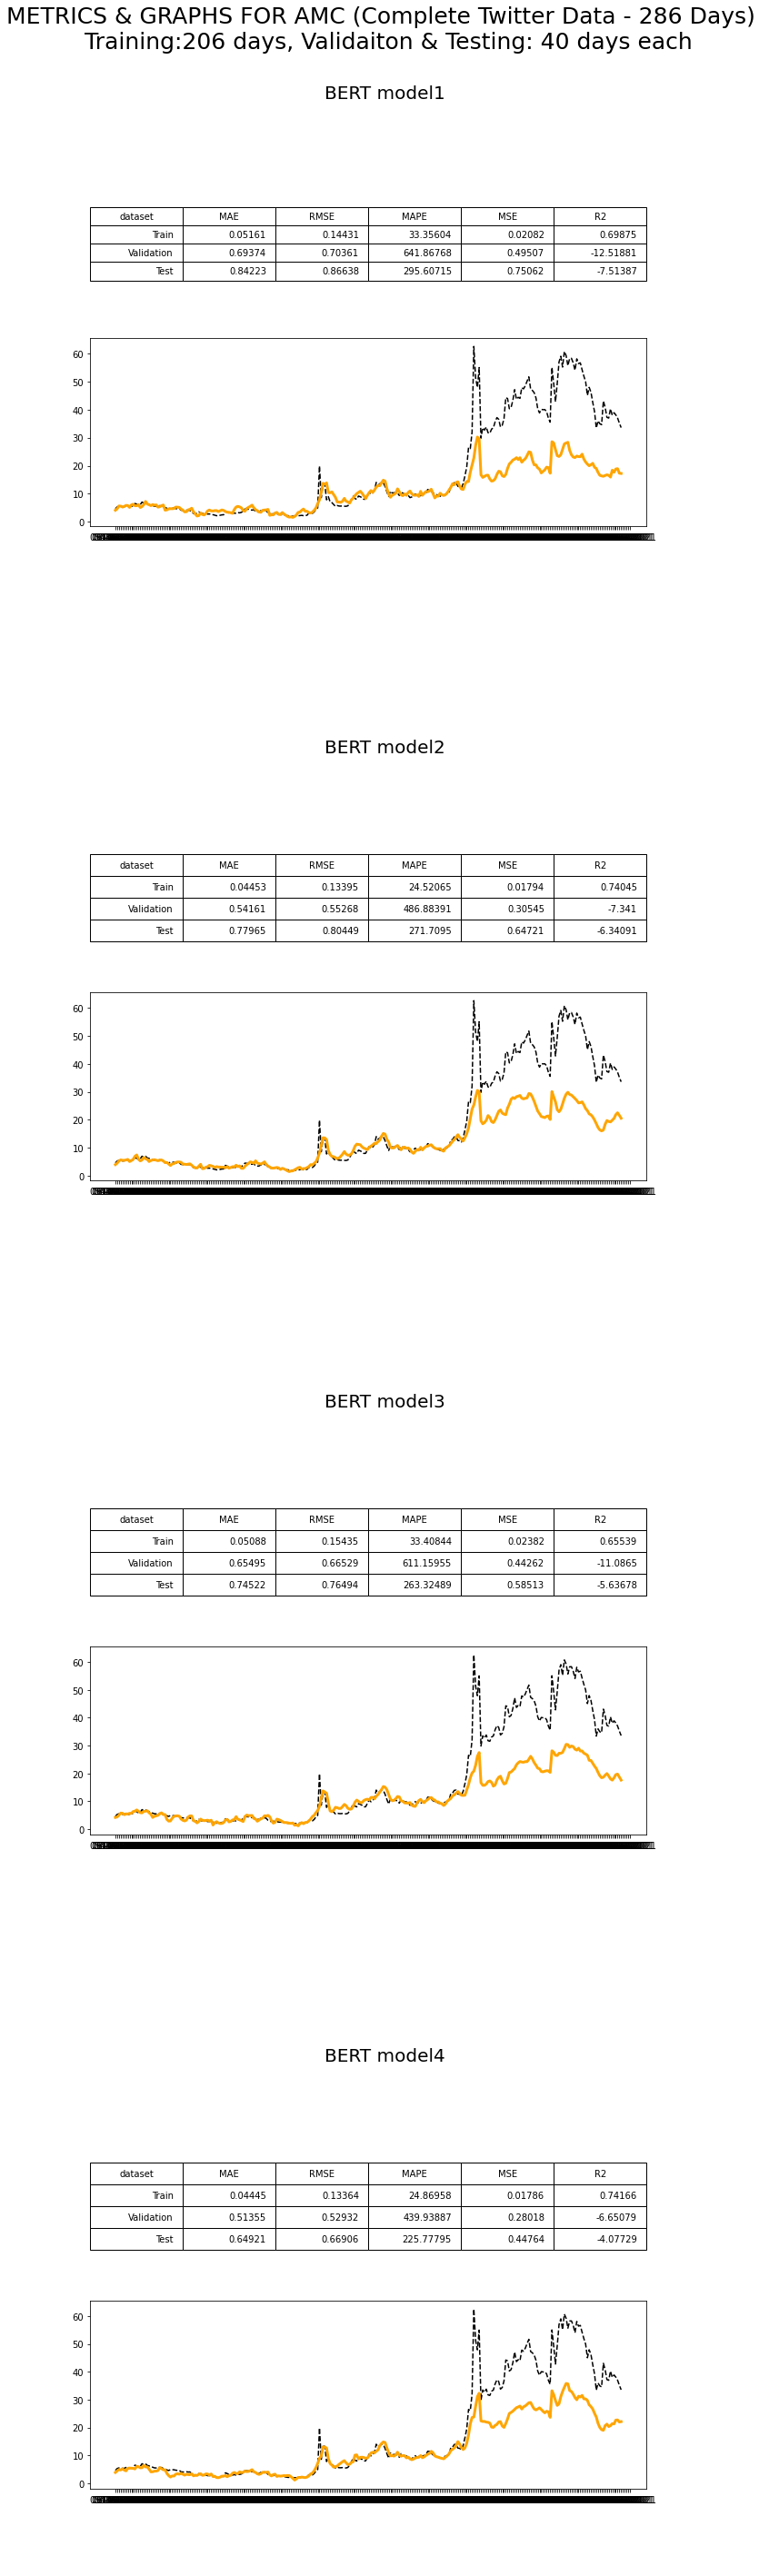

In [13]:
import matplotlib.pyplot as plt

# fig = plt.figure(constrained_layout=True, figsize=(30, 60))
fig = plt.figure(figsize=(10, 40))
fig.suptitle('METRICS & GRAPHS FOR AMC (Complete Twitter Data - 286 Days) \n Training:206 days, Validaiton & Testing: 40 days each', fontsize=25, fontweight=5)
subfigs = fig.subfigures(nrows=len(results_df), ncols=1, hspace = 1)

subfig_no = 0

for model, model_df in results_df.items():
    
    ax = subfigs[subfig_no].subplots(nrows=2, ncols=1)
    subplot_col_n = 0
    subfigs[subfig_no].suptitle(f'BERT {model}', fontsize=20, y=0.80)
    
    #--plot the metrics results
    tmp = model_df['metrics'].iloc[:,:6]
    tmp.iloc[:,1:6]=tmp.iloc[:,1:6].applymap(lambda x: float('%.5f'%(x)))
    table = ax[subplot_col_n].table(cellText=tmp.values, colLabels=model_df['metrics'].columns, loc='center')
    ax[subplot_col_n].patch.set_visible(False)
    ax[subplot_col_n].axis('off')
    ax[subplot_col_n].axis('tight')
#     ax[subplot_col_n].set_title('Twitter', pad=-14, y=1)
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1,2)

    #--increment row_n
    subplot_col_n += 1

    #--plot the line graphs
    plot_df = model_df['close']
    ax[subplot_col_n].plot(plot_df['Date'], plot_df['true_close'], color='black', linestyle='--');
    ax[subplot_col_n].plot(plot_df['Date'], plot_df['pred_close'], color='orange', linewidth=3);

    subfig_no += 1
    
    fig.subplots_adjust(left=0.05, bottom=None, right=None, top=0.7, wspace=0.1, hspace=0.0001)

path = r'C:\\Users\\Karthik\\Desktop\\Dissertation\\Plots and metrics\\Extra\\'
plt.savefig(f'{path}AMC Predictions with complete twitter data.jpg')
plt.show();